# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

_This notebook was generated with the assistance of AI. Please use caution: always validate code, results, and interpretations when working with research data._

This notebook provides an introduction to [Dandiset 001174](https://dandiarchive.org/dandiset/001174/0.250331.2218), which contains in vivo calcium imaging data collected from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques during resting and behavioral (reaching) conditions. The data were collected using a one-photon miniscope system.

## What this notebook covers
- Overview of Dandiset 001174 and its contents.
- Listing and selection of NWB files using the DANDI API.
- Loading data from NWB files via remote streaming.
- Visualizing raw imaging data, processed calcium traces, event amplitudes, and segmentation masks.
- Exploration of both spontaneous and task-related sessions.

## Required packages
To run this notebook, you need:
- `dandi`
- `remfile`
- `h5py`
- `pynwb`
- `matplotlib`
- `numpy`

These packages are assumed to be installed in your environment.

## Dandiset 001174 Overview

- **Title**: Calcium imaging in SMA and M1 of macaques
- **Species**: Rhesus macaque (_Macaca mulatta_)
- **Modalities**: One-photon miniscope calcium imaging, ROI segmentation, processed event/fluorescence traces
- **Sessions**: Spontaneous and reaching task conditions
- **Data Format**: NWB (Neurodata Without Borders)
- **Dandiset Link**: [https://dandiarchive.org/dandiset/001174/0.250331.2218](https://dandiarchive.org/dandiset/001174/0.250331.2218)

## Load and Explore Dandiset Assets

The code below demonstrates how to list available NWB files from the dandiset using the DANDI API.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Specify Dandiset ID and version
dandiset_id = "001174"
dandiset_version = "0.250331.2218"

# Initialize the DANDI API client and get the dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List some example NWB files in the dandiset
n_list = 10
assets = list(islice(dandiset.get_assets_by_glob("*.nwb"), n_list))
nwb_paths = [asset.path for asset in assets]
print("Example NWB files in the dandiset:")
for path in nwb_paths:
    print(path)

Example NWB files in the dandiset:
sub-V/sub-V_ses-20230309T110929_ophys.nwb
sub-Q/sub-Q_ophys.nwb
sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
sub-Q/sub-Q_ses-20221028T121142_ophys.nwb
sub-Q/sub-Q_ses-20221201T132256_ophys.nwb
sub-Q/sub-Q_ses-20221202T122907_ophys.nwb
sub-Q/sub-Q_ses-20221206T121002_ophys.nwb
sub-Q/sub-Q_ses-20220915T133954_ophys.nwb
sub-Q/sub-Q_ses-20221201T134628_ophys.nwb


## Select and Explore Example NWB Files

We will examine two example files:
1. A spontaneous session: `sub-Q/sub-Q_ophys.nwb`
2. A reaching task session: `sub-V/sub-V_ses-20230309T110929_ophys.nwb`

For each file, we'll display information and some key visualizations.

### 1. Spontaneous Condition Example (`sub-Q/sub-Q_ophys.nwb`)

We'll stream the file remotely, inspect raw imaging properties, number of ROIs, and visualize ROI 0's fluorescence and spatial mask.

In [2]:
import remfile
import h5py
import pynwb

# File path (spontaneous condition)
asset_path = "sub-Q/sub-Q_ophys.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))

# Stream the file remotely
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, "r")
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# --- Extract data properties ---
# Raw imaging data
ops = nwb.acquisition['OnePhotonSeries']
raw_data_shape = ops.data.shape
raw_data_dtype = ops.data.dtype

# Number of ROIs
segmentation = nwb.processing['ophys'].data_interfaces['ImageSegmentation']
plane_seg = segmentation.plane_segmentations['PlaneSegmentation']
num_rois = plane_seg.image_mask.shape[0]

# First 5 timepoints of fluorescence for ROI 0
fl = nwb.processing['ophys'].data_interfaces['Fluorescence']
roi_series = fl.roi_response_series['RoiResponseSeries']
fluor_first5_firstROI = roi_series.data[:5, 0]

print(f"Raw imaging data shape: {raw_data_shape}")
print(f"Raw imaging data dtype: {raw_data_dtype}")
print(f"Number of segmented ROIs/cells: {num_rois}")
print(f"First 5 timepoints of fluorescence for ROI 0: {fluor_first5_firstROI}")

Raw imaging data shape: (6041, 320, 200)
Raw imaging data dtype: uint16
Number of segmented ROIs/cells: 40
First 5 timepoints of fluorescence for ROI 0: [0. 0. 0. 0. 0.]


#### Plot: Fluorescence Trace and Spatial Mask (ROI 0)

We now plot the full fluorescence trace and cell mask for ROI 0.

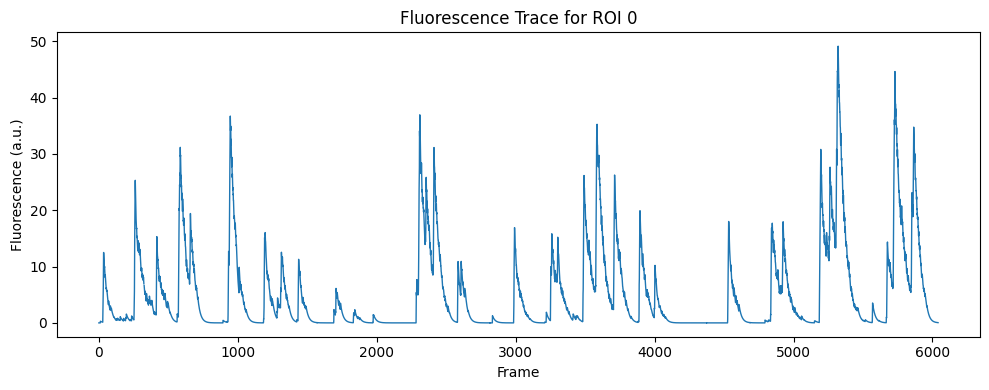

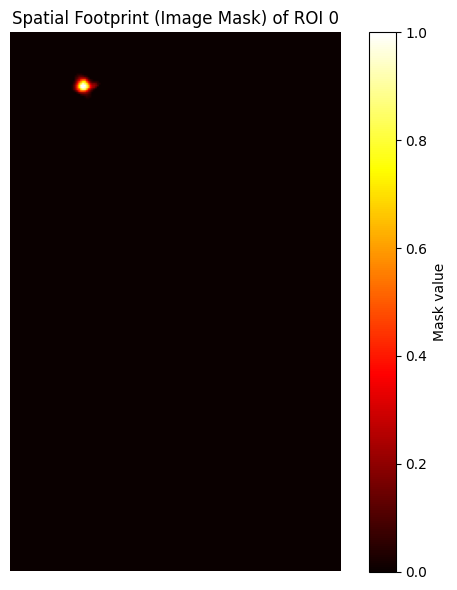

In [3]:
import matplotlib.pyplot as plt

# Get full fluorescence trace for ROI 0
fluor_trace = roi_series.data[:, 0]

# Get image mask for ROI 0
mask = plane_seg.image_mask[0]

# Plot fluorescence trace
plt.figure(figsize=(10, 4))
plt.plot(fluor_trace, lw=1)
plt.title('Fluorescence Trace for ROI 0')
plt.xlabel('Frame')
plt.ylabel('Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

# Plot spatial footprint
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='hot')
plt.title('Spatial Footprint (Image Mask) of ROI 0')
plt.axis('off')
plt.colorbar(label='Mask value')
plt.tight_layout()
plt.show()

#### Plot: Event Amplitude Trace and Histogram (Spontaneous Session)

We'll visualize the event amplitude trace for ROI 0, and then show the distribution of all nonzero event amplitudes across ROIs and timepoints.

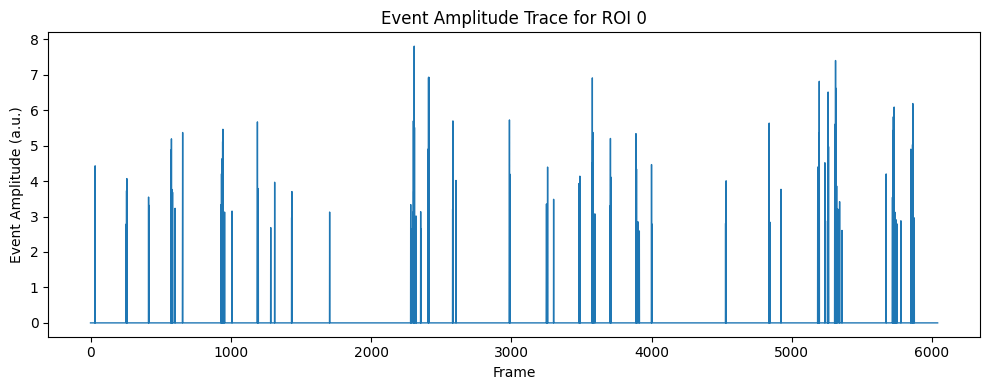

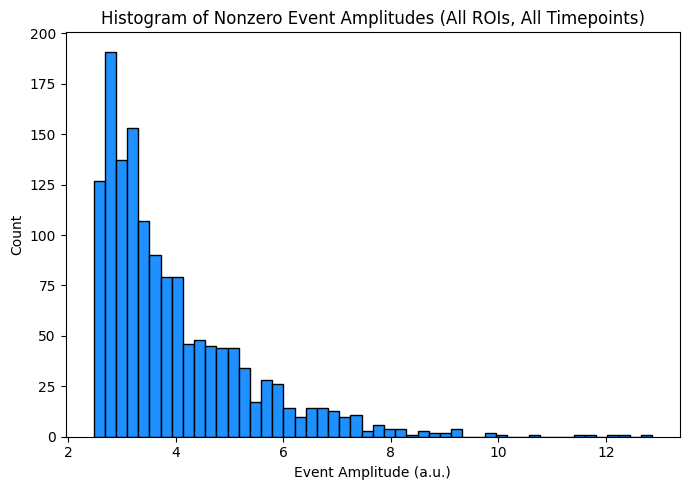

In [4]:
# Event amplitude trace for ROI 0
event_ampl_series = nwb.processing['ophys'].data_interfaces['EventAmplitude']
event_ampl_trace_roi0 = event_ampl_series.data[:, 0]
event_ampl_all = event_ampl_series.data[:, :]

# Plot event amplitude trace for ROI 0
plt.figure(figsize=(10, 4))
plt.plot(event_ampl_trace_roi0, lw=1)
plt.title('Event Amplitude Trace for ROI 0')
plt.xlabel('Frame')
plt.ylabel('Event Amplitude (a.u.)')
plt.tight_layout()
plt.show()

# Histogram of nonzero event amplitudes (all ROIs/timepoints)
import numpy as np
nonzero_amplitudes = event_ampl_all[event_ampl_all > 0]

plt.figure(figsize=(7, 5))
plt.hist(nonzero_amplitudes, bins=50, color='dodgerblue', edgecolor='k')
plt.title('Histogram of Nonzero Event Amplitudes (All ROIs, All Timepoints)')
plt.xlabel('Event Amplitude (a.u.)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2. Arm Reaching Task Example (`sub-V/sub-V_ses-20230309T110929_ophys.nwb`)

Let's repeat the main analyses for a session during which the animal performed an arm reaching task.

In [5]:
# File path (reaching task condition)
asset_path_task = "sub-V/sub-V_ses-20230309T110929_ophys.nwb"
asset_task = next(dandiset.get_assets_by_glob(asset_path_task))

# Stream remotely and load NWB file
remote_file_task = remfile.File(asset_task.download_url)
h5_file_task = h5py.File(remote_file_task, "r")
io_task = pynwb.NWBHDF5IO(file=h5_file_task, load_namespaces=True)
nwb_task = io_task.read()

# Get properties
ops_task = nwb_task.acquisition['OnePhotonSeries']
raw_data_shape_task = ops_task.data.shape
raw_data_dtype_task = ops_task.data.dtype

segmentation_task = nwb_task.processing['ophys'].data_interfaces['ImageSegmentation']
plane_seg_task = segmentation_task.plane_segmentations['PlaneSegmentation']
num_rois_task = plane_seg_task.image_mask.shape[0]

fl_task = nwb_task.processing['ophys'].data_interfaces['Fluorescence']
roi_series_task = fl_task.roi_response_series['RoiResponseSeries']
fluor_first5_firstROI_task = roi_series_task.data[:5, 0]

print(f"Raw imaging data shape: {raw_data_shape_task}")
print(f"Raw imaging data dtype: {raw_data_dtype_task}")
print(f"Number of segmented ROIs/cells: {num_rois_task}")
print(f"First 5 timepoints of fluorescence for ROI 0: {fluor_first5_firstROI_task}")

Raw imaging data shape: (5185, 1280, 800)
Raw imaging data dtype: uint16
Number of segmented ROIs/cells: 11
First 5 timepoints of fluorescence for ROI 0: [0.         0.24393004 0.22219317 0.2023933  0.56658596]


#### Plot: Fluorescence Trace and Spatial Mask (ROI 0, Reaching Task)

Visualize both the temporal and spatial profile for ROI 0 during the arm reaching task.

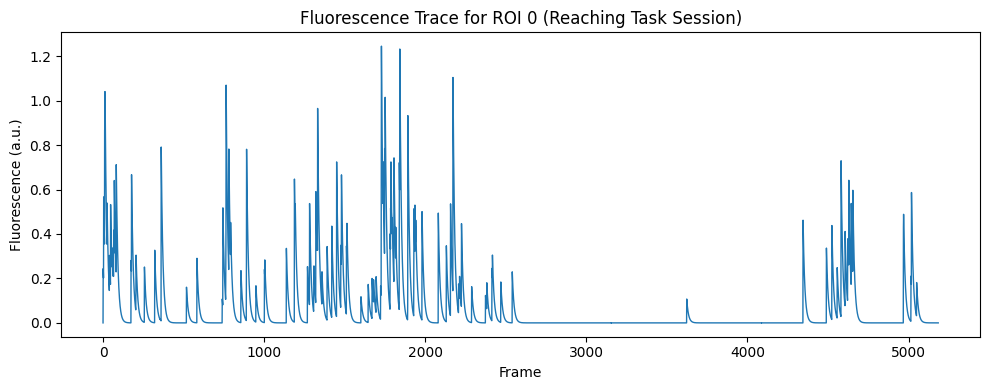

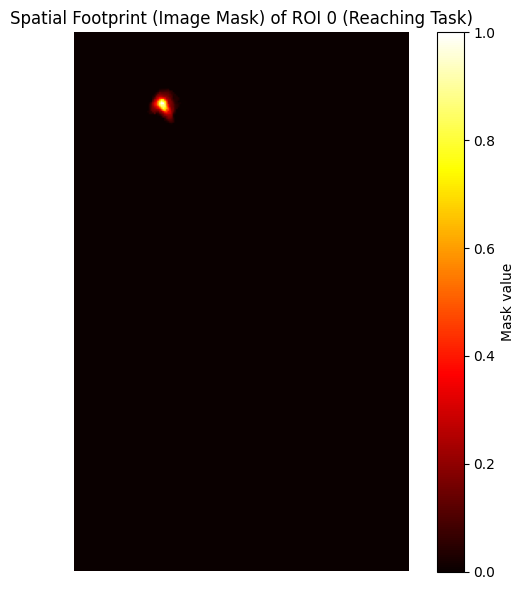

In [6]:
# Fluorescence trace and mask for ROI 0
fluor_trace_task = roi_series_task.data[:, 0]
mask_task = plane_seg_task.image_mask[0]

# Plot fluorescence trace
plt.figure(figsize=(10, 4))
plt.plot(fluor_trace_task, lw=1)
plt.title('Fluorescence Trace for ROI 0 (Reaching Task Session)')
plt.xlabel('Frame')
plt.ylabel('Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

# Plot spatial footprint
plt.figure(figsize=(6, 6))
plt.imshow(mask_task, cmap='hot')
plt.title('Spatial Footprint (Image Mask) of ROI 0 (Reaching Task)')
plt.axis('off')
plt.colorbar(label='Mask value')
plt.tight_layout()
plt.show()

## Summary and Next Steps

- This notebook demonstrated how to find, load, and visualize core optical physiology data from Dandiset 001174.
- You explored both spontaneous and reaching task sessions, and inspected neural fluorescence, segmentation, and event amplitude streams.
- You can adapt these patterns to explore additional sessions, ROIs, or further analyze temporal patterns and population-level activity.

If you require behavioral or task event streams, check the session metadata or accompanying documentation for how to relate times to experimental epochs.

_For further information, refer to the [dandiset page](https://dandiarchive.org/dandiset/001174/0.250331.2218) or original dataset paper/preprint._